
Open in Colab:https://colab.research.google.com/drive/1i9EedyJk26UH8HTsEY1bYlzgIcYX7sqI

#  Μέρος Α

Στο πρώτο μέρος της εργασίας θα ασχοληθούμε με τον τομέα της υπολογιστικής όρασης(αναγνώριση προτύπων). Πιο συγκεκριμένα, θα αφοσιωθούμε στη μελέτη, στη σχεδίαση και στη δημιουργία ενός CNN μοντέλου το οποίο θα πρέπει να αναγνωρίζει 10 διαφορετικές κατηγορίες από ένα σύνολο 10000 φωτογραφιών.
Τα δεδομένα για την εκπαίδευση του μοντέλου μας θα τα αντλήσουμε από την CIFAR-10 dataset και οι κατηγορίες που θα πρέπει να ξεχωρίζει το μοντέλο μας είναι οι παρακάτω.

![alt text](https://miro.medium.com/max/505/1*sGochNLZ-qfesdyjadgXNw.png)


Εισαγωγή των απαραίτητον βιβλιοθηκών.

In [2]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

!pip install ipython-autotime
%load_ext autotime

from google.colab import drive
drive.mount('/content/gdrive')

Using TensorFlow backend.


  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=d4da2a737d17426f18652f29ed9523a0adcae353ecb55c193b66f1cc6a6a1443
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Να σημειωθεί εδω οτι η βάση μας θα πρέπει να βρίσκεται στο τρέχων directory σε ένα φάκελο με ονομασία "cifar-10-batches-py"

In [5]:
#change to the directory of the dataset
os.chdir("/content/gdrive/My Drive/ColabNotebooks/Assigment3")
!ls

Assigment3_CNN.h5  Assigment3.ipynb  cifar-10-batches-py  part2.h5
time: 2.07 s


In [3]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'
batch_size = 256
num_classes = 10
epochs = 200
batch_id = 3

class_names = ['airplane', 'automobile', 'bird', 
               'cat', 'deer', 'dog', 'frog',
               'horse', 'ship', 'truck']

time: 3.09 ms


Αφού εισάγαμε τις απαραίτητες βιβλιοθήκες το επόμενο βήμα είναι να φορτώσουμε την βάση μας. 

## ΜΈΘΟΔΟΙ

### ΔΕΔΟΜΈΝΑ

Τα αρχικά δεδομένα μας έχουν την μορφή (10000 x 3072), όπου ο αριθμός  (10000) αναπαριστά τον αριθμό της εικόνας, και ο αριθμός  (3072) αναπαριστά την ίδια την εικόνα, δηλαδή μια εικόνα των 32x32 pixels * 3 κανάλια (rgb).

Όμως γνωρίζουμε ότι σε ένα CNN μοντέλο οι εικόνες που δέχεται πρέπει να είναι της παρακάτω μορφής (width x height x num_channel). Άρα θα πρέπει να μεταμορφώσουμε την βάση μας σε αυτήν την μορφή. Η κάθε εικόνα αποτελείτε από 32x32 pixels και 3 κανάλια για το rgb. Αρία έχουμε 32x32x3 = 3072. 
Για να φέρουμε την βάση στην επιθυμητή μορφή θα πρέπει πρώτα να χρησιμοποιήσουμε την συνάρτηση __reshape__ 3072->(3,32,32) και έπειτα να χρησιμοποιήσουμε την __transpose__ ώστε τα δεδομένα μας να έχουν την επιθυμητή μορφή (3,32,32)->(32,32,3).

Η  __transpose__ δέχεται μια λίστα από αριθμούς όπου δηλώνουμε την σειρά που θέλουμε να μπουν οι στήλες του παλιού πίνακα στον καινούργιο πίνακα. Π.χ με τον πίνακα (num_channel, width, height)  αν θέλουμε ο τελικός πίνακας να έχει την μορφή (width x height x num_channel) θα πρέπει (να επισημάνουμε εδώ ότι στον πίνακα της μορφής (num_channel, width, height) το num_channel βρίσκεται στην 0 θέση, τα στοιχεία width βρίσκεται στην 1 θέση και 
τα στοιχεία height βρίσκεται στην 2 θέση) να δώσουμε την λίστα (1, 2, 0)έτσι δηλώνουμε ότι στον νέο πινάκα μας στην πρώτη διάσταση θα είναι τα στοιχειά που βρίσκονται στην θέση 1 δηλαδή (width) του προηγουμένου πίνακα, στην δεύτερη διάσταση θα είναι τα στοιχειά που βρίσκονται στην θέση 2 και στην τρίτη διάσταση θα είναι τα στοιχειά που βρίσκονται στην θέση 0. 


In [0]:
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

In [0]:

# load dataset
features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
features.shape, len(labels)

((10000, 32, 32, 3), 10000)

Επιλέγουμε το validation set να είναι το 1000 παραδείγματα






In [0]:
#validation set
index_of_validation = int(len(features) * 0.1)

Βοηθητική συνάρτηση για την απεικόνιση της βάσης και τον προβλέψεων.

In [0]:
def plot_images(images, cls_true, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    
    hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        xlabel = "Class: {0}".format(cls_true_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    
    plt.show()

Αυτές είναι οι εικόνες που το νευρωνικό δίκτυο θα δεχτεί.


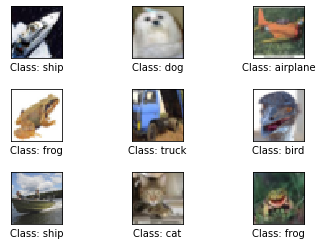

In [0]:
images = features[:9]
cls_true = labels[:9]
# Plot the images and labels 
plot_images(images=images, cls_true=cls_true, smooth=False)

Παρατηρούμε ότι οι εικόνες που θα δεχτεί το δίκτυο είναι "πιξελιαρισμένες" θα ήταν καλύτερο να εφαρμόσουμε ένα "σμουθάρισμα" για να τις βλέπουμε καλύτερα.


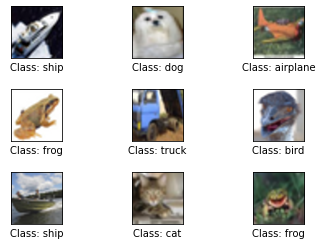

In [0]:
# Plot the images and labels 
plot_images(images=images, cls_true=cls_true, smooth=True)

### ΣΥΝΑΡΤΗΣΕΙΣ ΠΟΥ ΧΡΗΣΗΜΟΠΟΙΗΘΗΚΑΝ

#### Νormalize

Φτιάχνουμε μια συνάρτηση η οποία δέχεται τα δεδομένα μας και επιστρέφει την βάση με κανονικοποιημένες τιμές. Η τεχνική που χρησιμοποιήθηκε είναι η Min-Max Normalization.


In [0]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x 
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

In [0]:
# preprocess the 90% of the whole dataset of the batch
  # - normalize the features
# first 9000 images
x_train = normalize(features[:-index_of_validation])

print('Before Normalization: ', features[0,:1,:1,:3])
print('After Normalization: ', x_train[0,:1,:1,:3])

Before Normalization:  [[[26 23 32]]]
After Normalization:  [[[0.10196078 0.09019608 0.1254902 ]]]


In [0]:
  # - one_hot_encode the lables

y_train = to_categorical(labels[:-index_of_validation])
y_train.shape

(9000, 10)

In [0]:
#validation set
valid_features = []
valid_labels = []
valid_features =normalize(features[-index_of_validation:])
valid_labels = to_categorical(labels[-index_of_validation:])
valid_features.shape, valid_labels.shape

((1000, 32, 32, 3), (1000, 10))

### Μοντέλο

In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(32, 32, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# print model summary
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1605760  

Κάνουμε train το μοντέλο μας.

In [0]:
 model_name = 'Assigment3_CNN.h5'
# model.save(model_name)
import pathlib
file = pathlib.Path(model_name)
if file.exists ():
    print ("File exist")
    model = keras.models.load_model(model_name)
else:
    print ("File doesn't exist")
    #fit model parameters, given a set of training data
    model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(valid_features, valid_labels))
    model.save(model_name)

Πάμε να φορτώσουμε τα δεδομένα για το testing.


In [0]:
# load the test dataset
with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
    batch = pickle.load(file, encoding='latin1')

# preprocess the testing data
x_test = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
test_labels = batch['labels']
y_test = to_categorical(test_labels)

time: 85.4 ms


In [0]:
y_test_predictions_vectorized = model.predict(x_test)
y_test_predictions = np.argmax(y_test_predictions_vectorized, axis=1)

time: 798 ms


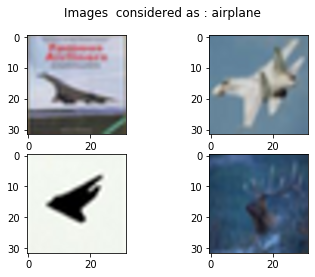

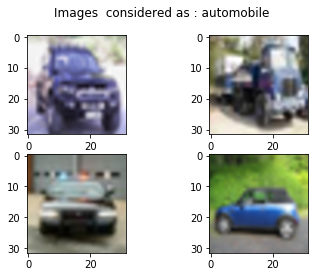

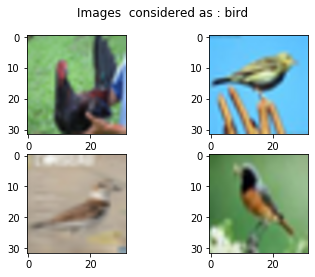

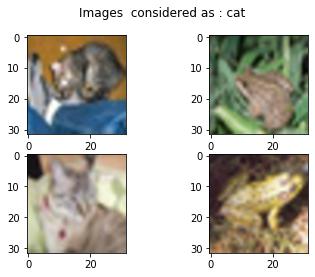

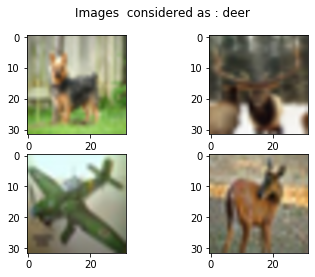

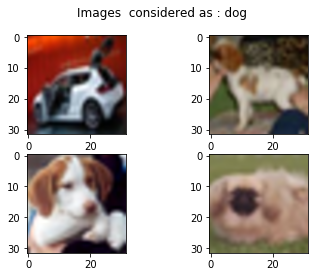

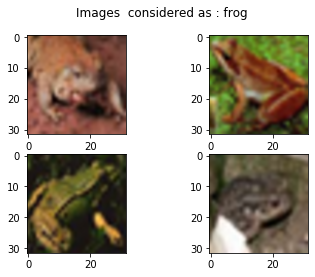

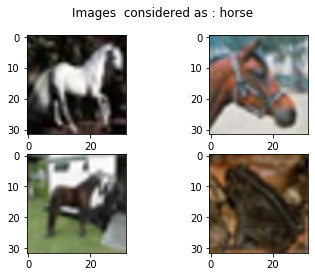

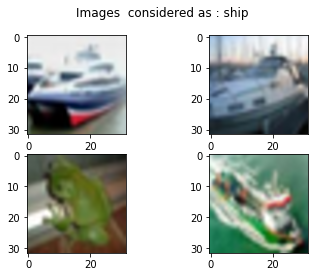

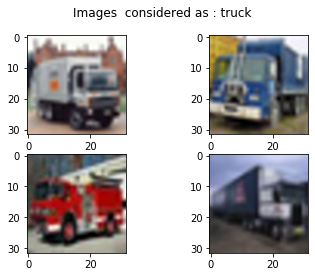

time: 23.7 s


In [0]:
class_to_demonstrate = 0
interpolation = 'spline16'
while (sum(y_test_predictions == class_to_demonstrate) > 4):
    tmp_idxs_to_use = np.where(y_test_predictions == class_to_demonstrate)

    # create new plot window
    plt.figure()

    # plot 4 images as gray scale
    plt.subplot(221)
    plt.imshow(x_test[tmp_idxs_to_use[0][0], :, :, :], interpolation = 'spline16')
    plt.subplot(222)
    plt.imshow(x_test[tmp_idxs_to_use[0][1], :, :, :], interpolation = 'spline16')
    plt.subplot(223)
    plt.imshow(x_test[tmp_idxs_to_use[0][2], :, :, :], interpolation = 'spline16')
    plt.subplot(224)
    plt.imshow(x_test[tmp_idxs_to_use[0][3], :, :, :], interpolation = 'spline16')
    tmp_title = 'Images  considered as : ' + class_names[class_to_demonstrate]
    plt.suptitle(tmp_title)

    # show the plot
    plt.show()
    plt.pause(2)

    # update the class to demonstrate index
    class_to_demonstrate = class_to_demonstrate + 1

In [0]:
columns = ['Precision', 'Recall', 'F1 score', 'Accuracy']

results_DF = pd.DataFrame(columns=columns)

time: 9.07 ms


Συνάρτηση η οποία μας βοηθάει να μετρήσουμε την απόδοση του μοντέλου

In [0]:

def CalculateScores ( y_test, y_pred_test):
    """
    Function that calculate the score for each model and add the result results_DF dataFrame.

    """
    acc_test = accuracy_score(y_test, y_pred_test)

    pre_test = precision_score(y_test, y_pred_test, average='macro')
    
    rec_test = recall_score(y_test, y_pred_test, average='macro')
    
    f1_test = f1_score(y_test, y_pred_test, average='macro')

    #test
    results_DF.loc[len(results_DF)] = [pre_test]+ [rec_test] + [f1_test] + [acc_test]


time: 5.2 ms


In [0]:
CalculateScores(np.argmax(y_test, axis=1), y_test_predictions, )

time: 26.3 ms


In [0]:
results_DF

,Precision,Recall,F1 score,Accuracy
0,0.538942,0.4903,0.477035,0.4903


time: 16.6 ms


# Συμπεράσματα
Από τις παραπάνω μετρικές βλέπουμε ότι το μοντέλο μας δεν τα πάει πολύ καλά σε νέα δεδομένα. Το πιο πιθανό πρόβλημα είναι ότι τα δεδομένα εκπαίδευσης είναι λίγα. Σε μια επομένη υλοποίηση θα μπορούσαμε να χρησιμοποιήσουμε για την εκπαίδευση όλη την βάση. 

#  Μέρος Β

Στο δεύτερο μέρος της εργασίας θα αναπτύξουμε ένα μοντέλο LSTM το οποίο θα μπορεί να μοντελοποιήσει την πρόσθεση και την αφαίρεση μεταξύ ακέραιων αριθμών στο διάστημα [-99,99].




Εισαγωγή των απαραίτητον βιβλιοθηκών.


In [0]:
from random import seed
from random import randint
from numpy import array
from math import ceil
from math import log10
from numpy import argmax
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
import keras
import re

time: 8.79 ms


In [0]:
# define dataset
n_samples = 2000
n_numbers = 2
largest = 99
alphabet = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+','-', ' ']
n_chars = len(alphabet)
n_in_seq_length = n_numbers * ceil(log10(largest + 1)) + n_numbers + 1
n_out_seq_length = ceil(log10(n_numbers * (largest + 1))) + 2
# define LSTM configuration
n_batch = 10
n_epoch = 100

time: 3.9 ms


## ΜΕΘΟΔΟΙ

Σε αυτή την περίπτωση θα χρειαστεί να δημιουργήσουμε μονοί μας την βάση με τα δεδομένα. Το μόνο που χρειάζεται είναι να δημιουργήσουμε τυχαία παραδείγματα από προσθέσεις και αφαιρέσεις 2 αριθμόν και να αποθηκεύσουμε το αποτέλεσμα. 

### ΣΥΝΑΡΤΗΣΕΙΣ ΠΟΥ ΧΡΗΣΙΜΟΠΟΙΗΘΉΚΑΝ

#### random_sum_pairs, random_sub_pairs
θα χρησιμοποιήσουμε την συνάρτηση randint() για την δημιουργείται ακέραιων μεταξύ ενός διαστήματος


In [0]:
# generate lists of random integers and their sum
def random_sum_pairs(n_examples, n_numbers, largest):
    X, y = list(), list()
    for i in range(n_examples):
        in_pattern = [randint(1, largest) for _ in range(n_numbers)]
        out_pattern = sum(in_pattern)
        X.append(in_pattern)
        y.append(out_pattern)
    return X, y

# generate lists of random integers and their substraction
def random_sub_pairs(n_examples, n_numbers, largest):
    X, y = list(), list()
    for i in range(n_examples):
        in_pattern = [randint(1, largest) for _ in range(n_numbers)]
        out_pattern = in_pattern[0] - in_pattern[1]
        X.append(in_pattern)
        y.append(out_pattern)
    return X, y

time: 8.05 ms



#### to_string

Τα δεδομένα που θα δεχόμαστε και θα παρουσιάζουμε στην κονσόλα θα είναι σε μορφή αλφαριθμητικού. Όποτε θα πρέπει να βρούμε ένα τρόπο να αναπαραστήσουμε την έξοδο και την είσοδο. Η μεγαλύτερη πράξη που θα δέχεται το μοντέλο είναι το "-99+99" και η μεγαλύτερη έξοδος θα είναι το "-188". Αρα βλέπουμε ότι θέλουμε 6 χαρακτήρες για την είσοδο και 4 χαρακτήρες για την έξοδο. 



In [0]:
# convert data to strings
def to_string(X, y, sign, n_numbers, largest):
    max_length = n_numbers * ceil(log10(largest + 1)) + n_numbers + 1
    Xstr = list()
    for pattern in X:
        strp = sign.join([str(n) for n in pattern])
        strp = ''.join([' ' for _ in range(max_length - len(strp))]) + strp
        Xstr.append(strp)
    max_length = ceil(log10(n_numbers * (largest + 1))) + 2
    ystr = list()
    for pattern in y:
        strp = str(pattern)
        strp = ''.join([' ' for _ in range(max_length - len(strp))]) + strp
        ystr.append(strp)
    return Xstr, ystr

time: 7.2 ms


Ας δούμε ένα παράδειγμα για το πως διαμορφώνεται η είσοδος και η έξοδος με το padding.


In [0]:
seed(1)
# generate pairs
X, y = random_sum_pairs(1, 2, 99)
print(X, y)
# convert to strings
X, y = to_string(X, y,'+', 2, 99)
print(X, y)

[[18, 73]] [91]
['  18+73'] ['   91']
time: 3.4 ms


#### integer_encode

Οπως αναφέραμε και πιο πάνω τα δεδομένα που θα δεχόμαστε θα είναι σε μορφή αλφαριθμητικού άρα θα πρέπει να φτιάξουμε μια ρουτίνα που θα μετατρέπει τα αλφαριθμητικά σε ακέραιους αριθμούς για το νευρωνικό μας μοντέλο.


In [0]:
# integer encode strings
def integer_encode(X, y, alphabet):
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    Xenc = list()
    for pattern in X:
        integer_encoded = [char_to_int[char] for char in pattern]
        Xenc.append(integer_encoded)
    yenc = list()
    for pattern in y:
        integer_encoded = [char_to_int[char] for char in pattern]
        yenc.append(integer_encoded)
    return Xenc, yenc

time: 6.99 ms


In [0]:
def one_hot_encode(X, y, max_int):
    Xenc = list()
    for seq in X:
        pattern = list()
        for index in seq:
            vector = [0 for _ in range(max_int)]
            vector[index] = 1
            pattern.append(vector)
        Xenc.append(pattern)
    yenc = list()
    for seq in y:
        pattern = list()
        for index in seq:
            vector = [0 for _ in range(max_int)]
            vector[index] = 1
            pattern.append(vector)
        yenc.append(pattern)
    return Xenc, yenc

time: 7.89 ms


Μαζεύουμε όλα τα βήματα σε μια συνάρτηση.


In [0]:
# generate an encoded dataset
def generate_data(n_samples, n_numbers, largest, alphabet):
    # generate pairs
    X_sum, y_sum = random_sum_pairs(n_samples, n_numbers, largest)
    X_sub, y_sub = random_sub_pairs(n_samples, n_numbers, largest)

    # convert to strings
    X, y = to_string(X_sum, y_sum, '+', n_numbers, largest)
    X1, y1 = to_string(X_sub, y_sub, '-', n_numbers, largest)
    # concatenate the sums and subs
    X += X1
    y += y1
    # integer encode
    X, y = integer_encode(X, y, alphabet)
    # one hot encode
    X, y = one_hot_encode(X, y, len(alphabet))
    # return as numpy arrays
    X, y = array(X), array(y)
    return X, y

time: 8.06 ms


#### invert

Τέλος πρέπει να μετατρέψουμε τα κωδικοποιημένα δεδομένα στην αρχική τους μορφή για να μπορέσουμε να καταλάβουμε αν η πρόβλεψη είναι σωστή.


In [0]:
# invert encoding
def invert(seq, alphabet):
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    strings = list()
    for pattern in seq:
        string = int_to_char[argmax(pattern)]
        strings.append(string)
    return ''.join(strings)

time: 2.12 ms


### Μοντέλο

In [0]:
# create LSTM
model = Sequential()
model.add(LSTM(100, input_shape=(n_in_seq_length, n_chars)))
model.add(RepeatVector(n_out_seq_length))
model.add(LSTM(50, return_sequences=True))
model.add(TimeDistributed(Dense(n_chars, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               45600     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 50)             30200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 13)             663       
Total params: 76,463
Trainable params: 76,463
Non-trainable params: 0
_________________________________________________________________
None
time: 526 ms


In [0]:
 model_name = 'part2.h5'
# model.save(model_name)
import pathlib
file = pathlib.Path(model_name)
if file.exists ():
    print ("File exist")
    model = keras.models.load_model(model_name)
else:
    #fit model parameters, given a set of training data
    for i in range(n_epoch):
        X, y = generate_data(n_samples, n_numbers, largest, alphabet)
        print(i)
        model.fit(X, y, epochs=1, batch_size=n_batch)
    model.save(model_name)

File exist
time: 2.55 s


Ας δούμε σε 10 τυχαία παραδείγματα πως συμπεριφέρεται το μοντέλο.


In [0]:
n_samples = 10
# evaluate on some new patterns
X, y = generate_data(n_samples, n_numbers, largest, alphabet)
result = model.predict(X, batch_size=n_batch, verbose=0)
# calculate error
expected = [invert(x, alphabet) for x in y]
predicted = [invert(x, alphabet) for x in result]
# show some examples
for i in range(20):
    print()
    print('Expected=%s, Predicted=%s' % (expected[i], predicted[i]))


Expected=  107, Predicted=  107

Expected=   49, Predicted=   49

Expected=  162, Predicted=  162

Expected=  119, Predicted=  119

Expected=  133, Predicted=  133

Expected=   40, Predicted=   40

Expected=   67, Predicted=   67

Expected=  106, Predicted=  106

Expected=  176, Predicted=  176

Expected=  100, Predicted=  100

Expected=   32, Predicted=   32

Expected=  -58, Predicted=  -58

Expected=  -46, Predicted=  -46

Expected=  -27, Predicted=  -27

Expected=    1, Predicted=    1

Expected=  -80, Predicted=  -80

Expected=   68, Predicted=   68

Expected=  -39, Predicted=  -39

Expected=  -27, Predicted=  -27

Expected=   89, Predicted=   89
time: 229 ms


Το επόμενο βήμα είναι η ανάγνωση αλφαριθμητικών από την κονσόλα και η εισαγωγή τους στο μοντέλο ώστε να δούμε αν προβλέπει σωστά. Αυτό το πετυχαίνουμε με την βοήθεια των δυο παρακάτω συναρτήσεων που είναι υπεύθυνες για τον υπολογισμό της πράξης που έδωσε ο χρήστης και η κωδικοποίηση της για την εισαγωγή στο μοντέλο.


In [0]:
# generate an encoded dataset
def run_Input(x1, x2, sign, n_numbers, alphabet):
    X, y = list(), list()
    X = [x1,  x2]
    if sign == '+':
        y = x1 + x2
    elif sign == '-':
        y = x1 - x2
    # convert to strings
    X, y = to_string_Input(X, y, sign, n_numbers, 10)
    # integer encode
    X, y = integer_encode(X, y, alphabet)
    # one hot encode
    X, y = one_hot_encode(X, y, len(alphabet))
    # return as numpy arrays
    X, y = array(X), array(y)
    return X, y

time: 6.21 ms


In [0]:
# convert data to strings
def to_string_Input(X, y, sign, n_numbers, largest):
    max_length = n_numbers * ceil(log10(largest + 1)) + n_numbers + 1
    Xstr = list()

    strp = sign.join([str(n) for n in X])
    strp = ''.join([' ' for _ in range(max_length - len(strp))]) + strp
    Xstr.append(strp)
        
    max_length = ceil(log10(n_numbers * (largest + 1))) + 2
    ystr = list()
    strp = str(y)
    strp = ''.join([' ' for _ in range(max_length - len(strp))]) + strp
    ystr.append(strp)
    return Xstr, ystr

time: 9.88 ms


Το μοντέλο περιμένει συγκεκριμένη μορφή αλφαριθμητικού και για να το ελέγξουμε την είσοδο του χρήστη χρησιμοποιούμε regex.


In [0]:
p = re.compile('\d{1,2}(\+|\-)\d{1,2}')

while True:
    userType = input('Please enter the equation: ')
    userType.replace(" ", "")
    if p.match(userType):
        pattern = r'([\+\-])'
        resultType = re.split(pattern, userType)
        x1 = int(resultType[0])
        x2 = int(resultType[2])
        
        X, y = run_Input(x1, x2, resultType[1], n_numbers, alphabet)
        result = model.predict(X,verbose=0)
        # calculate error
        predicted = [invert(x, alphabet) for x in result]
        print('Equation: ', resultType)
        print('Predicted=%s' % (predicted))
    elif userType =='stop':
        break
    else:
        print("..The equation you entered is not valid, please entar a valid equation")
        print("..Example: 99+99, 99-99")
        print("...Too much math for today? press STOP to exit")
        

Please enter the equation: 2+2
Equation:  ['2', '+', '2']
Predicted=['    4']
Please enter the equation: 50+50
Equation:  ['50', '+', '50']
Predicted=['  100']
Please enter the equation: 90-99
Equation:  ['90', '-', '99']
Predicted=['   -9']
Please enter the equation: 8*8
The equation you entered is not valid, please entar a valid equation
Example: 99+99, 99-99
Too much math for today? press STOP to exit
Please enter the equation: 99+99
Equation:  ['99', '+', '99']
Predicted=['  198']
Please enter the equation: 99-99
Equation:  ['99', '-', '99']
Predicted=['    0']
Please enter the equation: STOP
The equation you entered is not valid, please entar a valid equation
Example: 99+99, 99-99
Too much math for today? press STOP to exit
Please enter the equation: stop
